## 03 Iteration 1 Data pre-processing & baseline model

**Summary**
- Since the target variable is quite imbalanced (90% of sellers churned), the baseline model would be to return that all of them churned and get a 90% accuracy. So values above that mark would be interesting.
- For the baseline model I used a simple decision tree iterating through 2 depth levels and cross folding to ensure reliable results. The choice on the model was based on multicolinearity and the scale of the data.
- Based on the variables used by the baseline tree, I decided to create related features:
    1. Days since seller creation date
    2. Month of seller creation
- Based on the distribution of the data, I decided to perform log transformation on avg_effective_delivery_days and avg_effective_earnings
- I splitted X and y, stratified into 80% test, 20% train, performed smote resample and standard scaler



## Baseline model

**Baseline model**
- Decision tree parameters and score:
    - parameters: max depth 2, no scaling
    - accuracy: 91, since the model is higher than the baseline, the results are interesting
    - AUC: 0.78
- Plotting the tree: the main variables for the segmentations were number of shared products and sellerID. Since the first one is an aggregate of all the time the seller has used the platform and the second one is continuous numerical data. I will include features to account for this situation, for example: days since seller creation date

- Additionally, I will continue to use recall as an evaluation metric for the next model

In [7]:
#Imports:
#General imports
import numpy as np
import pandas as pd
import re
import datetime


# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree



In [8]:
#Imports:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Sklearn metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




In [9]:
# SMOTE
from imblearn.over_sampling import SMOTE

In [10]:
#import and splitting
df8 = pd.read_csv("../data/elenas-it1-preprocessed4.csv",index_col=0)


In [11]:
dfbaseline = df8.copy()

dfbaseline.drop("created_at", axis=1, inplace=True)

In [12]:

X = dfbaseline.drop(columns="order_last_month")
y = dfbaseline["order_last_month"]

#Splitting data
X_trainbl, X_testbl, y_trainbl, y_testbl = train_test_split(X,y, test_size=0.2, stratify=y, random_state=24)

In [13]:
# fit decision tree without depth constrains: 
# Include a Confussion matrix

In [14]:
#Baseline Model
estimators = [('normalise', StandardScaler()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
            {'model': [DecisionTreeClassifier()],
             'normalise': [None], 'model__max_depth': [1, 2]}
]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose = 1)
fittedgrid = grid.fit(X_trainbl, y_trainbl)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [15]:
#Returning the best params:
fittedgrid.best_params_

{'model': DecisionTreeClassifier(max_depth=2),
 'model__max_depth': 2,
 'normalise': None}

In [16]:
#Measuring the score
fittedgrid.score(X_testbl, y_testbl)

0.9168614484160919

In [17]:

import plotly.graph_objects as go
from sklearn.metrics import roc_curve, roc_auc_score

# Predicted probabilities from the fitted grid search
y_pred_prob = fittedgrid.predict_proba(X_testbl)[:, 1]

# FPR, TPR and Thresholds
fpr, tpr, thresholds = roc_curve(y_testbl, y_pred_prob)

#AUC score
auc_score = roc_auc_score(y_testbl, y_pred_prob)

#ROC curve 
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC Curve (AUC = {:.2f})'.format(auc_score)
)

#Diagonal line trace
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Diagional line (equal measures)',
    line=dict(dash='dash')
)

#Layout & figure
layout = go.Layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    showlegend=True
)

fig = go.Figure(data=[roc_trace, diagonal_trace], layout=layout)


fig.show()


In [18]:
#Threshold based on the true positive rate:
desired_tpr = 0.907

# Max threshold within the desired tpr
desired_threshold = thresholds[np.argmax(tpr >= desired_tpr)]

#Results
print("Threshold for desired TPR:", desired_threshold)

Threshold for desired TPR: 0.9533418211775279


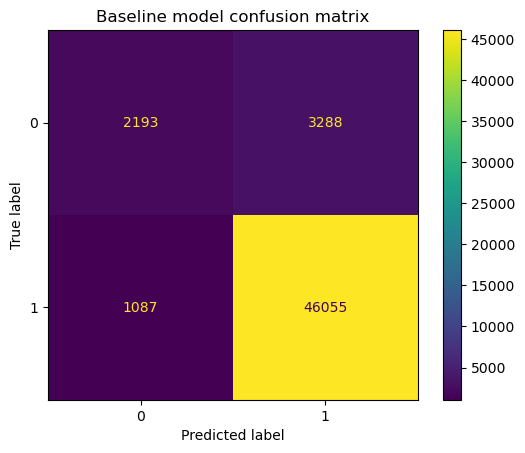

In [19]:
# Confusion matrix
cm = confusion_matrix(y_testbl, fittedgrid.predict(X_testbl), labels=fittedgrid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fittedgrid.best_estimator_.classes_)
disp.plot()
plt.title("Baseline model confusion matrix")
plt.show()


In [20]:

print(f"Precision: accuracy of churn predictions: {precision_score(y_testbl,fittedgrid.predict(X_testbl))}")
print(f"Recall: how many of the actual churns are correctly predicted as churn: {recall_score(y_testbl,fittedgrid.predict(X_testbl))}")
print(f"F1 score: {f1_score(y_testbl,fittedgrid.predict(X_testbl))}")


Precision: accuracy of churn predictions: 0.9333644083253957
Recall: how many of the actual churns are correctly predicted as churn: 0.9769420050061516
F1 score: 0.9546561641705964


Plotting a simple version of the tree

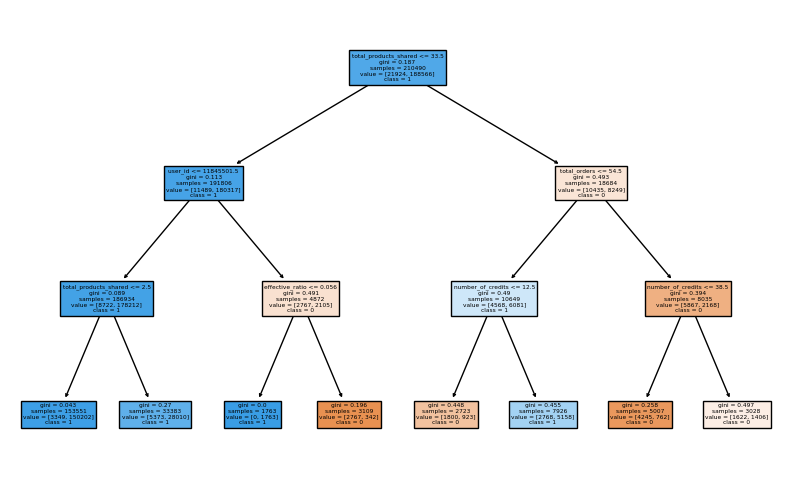

In [21]:
# Create a decision tree classifier with max depth of 3
dt = DecisionTreeClassifier(max_depth=3)

# Fit the classifier to the training data
dt.fit(X_trainbl, y_trainbl)

# Plot the decision tree
plt.figure(figsize=(10, 6))
plot_tree(dt, feature_names=X_trainbl.columns, class_names=["0", "1"], filled=True)
plt.show()

## Data preprocessing:

**Seller created_at:**  this column could be used to obtain 3 more features that could be valuable:
1. Days since creation: it is expected that a relevant fraction of the sellers that started in 2021 have already churned.
2. Seller creation month: It would be relevant to understand if there is an influence or seasonality depending on the month where they signed up. For examples, the ones in november - december that is the peak season in latam, could create the accounts to purchase for themselves instead of selling. 
3. Binning on seller creation days depending on the part of the month, since the incentives to acquire them are different

**When to split?** question 0

**Multicollinearity**
- Since the operational ratios add 1, return ratio will be dropped
- Number of clients has a correlation of 0.99 with total orders. As a result from the tree level above, number of clients will be dropped.

**Scaling** question 1
**PCA? / Kbest?** question 2
**Review distributions to see if there is a powerlaw** question 3



In [22]:
#Review
df8.head(5)

,Unnamed: 0,seller_id,created_at,user_id,total_orders,effective_ratio,rto_ratio,return_ratio,cancelled_ratio,departments_sold,...,avg_cart_items,avg_vendor_discount,number_of_products,number_of_categories,average_prod_existence_days,total_products_shared,number_of_credits,number_of_used_credits,avg_credit_amount,number_of_vouchers
0,0,11571677,2022-12-08,11600263,3.0,1.000000,0.000000,0.000000,0.000000,1.0,...,1.0,0.000000,3,3,453.000000,1,27,0,6222.222222,39
1,1,11583955,2022-12-11,11612556,1.0,1.000000,0.000000,0.000000,0.000000,1.0,...,1.0,7485.000000,1,1,423.000000,0,12,0,6500.000000,25
2,2,11604304,2022-12-16,11632958,7.0,0.714286,0.000000,0.142857,0.142857,1.0,...,1.0,186.875000,6,4,410.500000,5,24,0,6875.000000,46
3,3,11621203,2022-12-23,11649875,3.0,0.333333,0.333333,0.000000,0.333333,1.0,...,1.0,7581.666667,3,2,621.333333,0,7,0,4428.571429,26
4,4,11634194,2022-12-31,11662886,1.0,0.000000,0.000000,0.000000,1.000000,1.0,...,1.0,3800.000000,1,1,423.000000,0,3,0,7333.333333,7


In [23]:
#Seller Created at review:
#Convert to datetime
df8["created_at"] = pd.to_datetime(df8["created_at"])

#Seller creation month:
df8["seller_creation_month"] = df8["created_at"].dt.month

In [24]:
#Test to extract the days difference
df_test = df8.copy()

#Establishing the threshold date
threshold_date = pd.Timestamp('2023-03-30')

#Subtraction
df_test["creation_days"] = (threshold_date - df_test["created_at"]).dt.days

#Sanity check
df_test[["created_at", "creation_days"]].head(5)


,created_at,creation_days
0,2022-12-08,112
1,2022-12-11,109
2,2022-12-16,104
3,2022-12-23,97
4,2022-12-31,89


In [25]:
#Days since seller creation

#Seller creation threshold:
seller_creation_threshold = pd.Timestamp("2023-03-30")

#Substracting the dates
df8["days_since_seller_creation"] = (seller_creation_threshold - df8["created_at"])

#Converting into int
df8["days_since_seller_creation"] = df8["days_since_seller_creation"].astype(int)

#sanity check:
df8["days_since_seller_creation"].dtypes

dtype('int64')

In [26]:
#Binning test:
df_test["days"] = df_test["created_at"].dt.day
print(df_test["days"].describe().round(0))
# 'pd.cut' for binning
df_test["time_of_month"] = pd.cut(df_test["days"], bins=[0, 10, 20, 32], labels=[1, 2, 3])

df_test["time_of_month"] = df_test["time_of_month"].astype(int)

print(df_test["time_of_month"].dtype)


count    263113.0
mean         16.0
std           9.0
min           1.0
25%           8.0
50%          15.0
75%          23.0
max          31.0
Name: days, dtype: float64
int64


In [27]:
#Creating days of the month column
df8["days"] = df8["created_at"].dt.day
print(df8["days"].describe().round(0))

#binning
df8["creation_time_of_month"] = pd.cut(df8["days"], bins=[0, 10, 20, 32], labels=[1, 2, 3])

#converting to int
df8["creation_time_of_month"] = df8["creation_time_of_month"].astype(int)

#Sanity check:
df8["creation_time_of_month"].value_counts()

count    263113.0
mean         16.0
std           9.0
min           1.0
25%           8.0
50%          15.0
75%          23.0
max          31.0
Name: days, dtype: float64


3    89089
2    88553
1    85471
Name: creation_time_of_month, dtype: int64

In [28]:
#Dropping the columns:
cols_to_drop =["created_at", "days", "user_id", "number_of_clients", "return_ratio"]

df10 = df8.copy()

df10.drop(columns=cols_to_drop, inplace=True)


## Data distribution
- I plotted the different distributions of the variables. Some seemed like exponential distributions so decided to further analyze applying log transformation and plot them again. After the exercise decided to transform:
1. avg_effective_delivery_days
2. avg_effective_earnings

In [29]:
#Plotting distributions to determine if there are existing power laws
num_cols = df10.columns.to_list()

#Removing seller_id
num_cols.remove("seller_id")

#Removing activation time of month:
num_cols.remove("creation_time_of_month")




In [30]:
def num_col_dist(cols_list, df):
    """
    Plot the distributions of numerical columns in a DataFrame.

    Parameters:
        cols_list (list): A list of column names to plot the distributions.
        df (DataFrame): The DataFrame containing the numerical columns.
    """
    for col in cols_list:
        plt.figure()
        sns.histplot(data=df, x=col, bins=25)
        plt.axvline(df[col].mean(), color='r', linestyle='--', label='Mean')
        plt.axvline(df[col].median(), color='g', linestyle='--', label='Median')
        plt.xlabel(col)
        plt.title(col)
        plt.legend()
        plt.show()

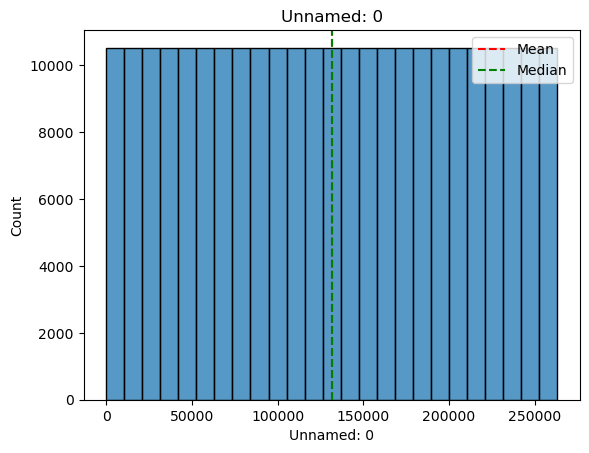

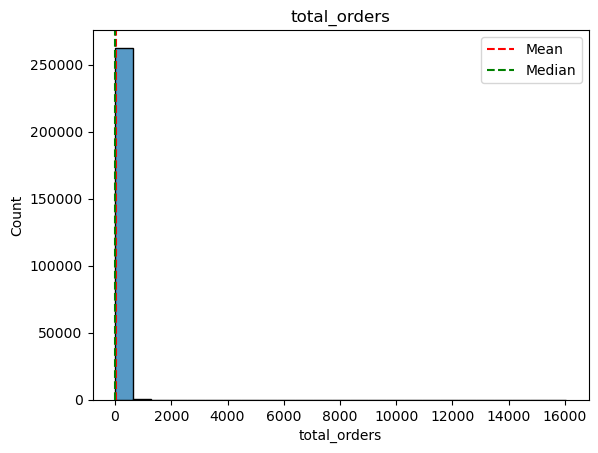

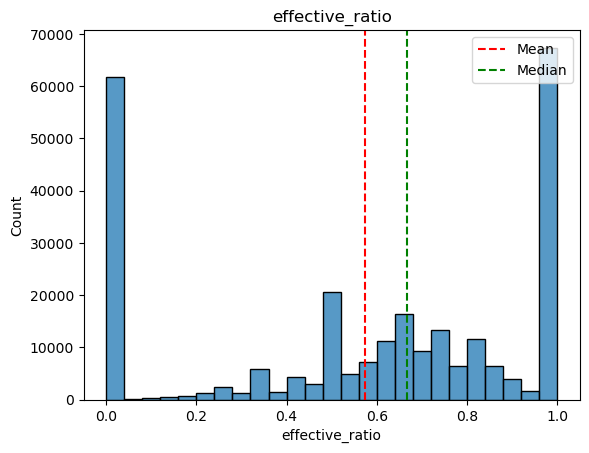

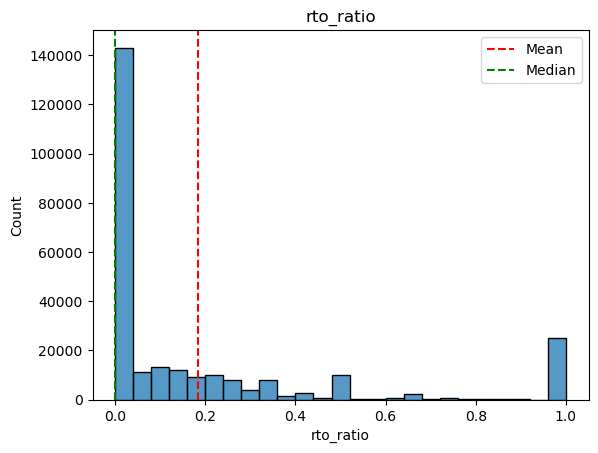

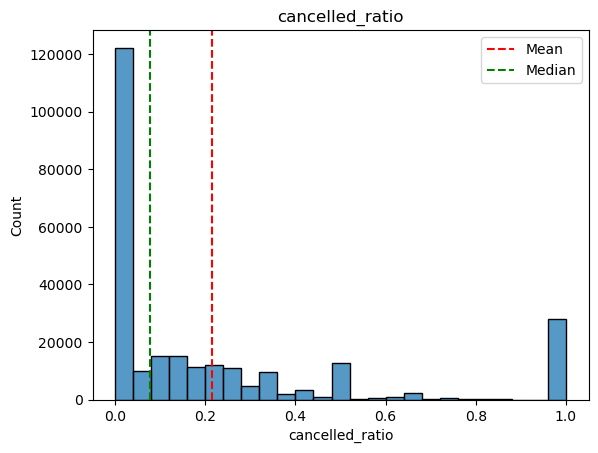

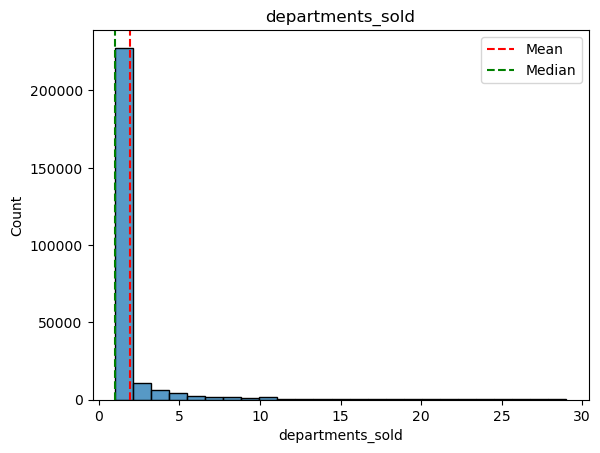

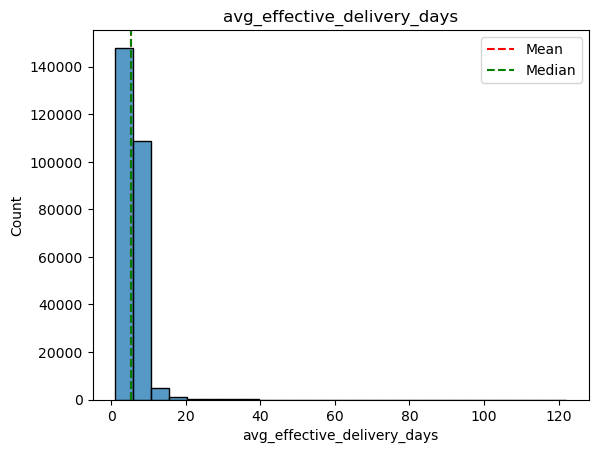

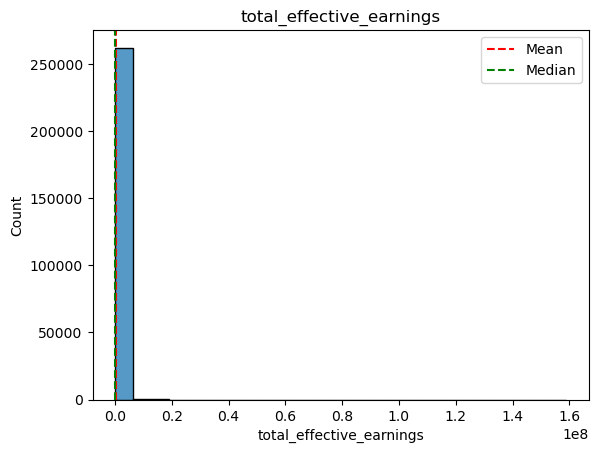

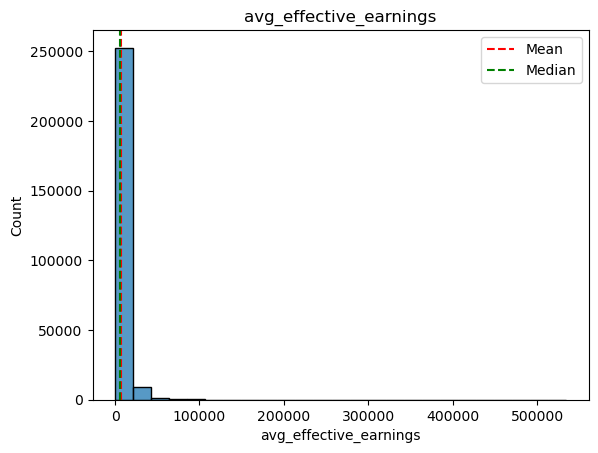

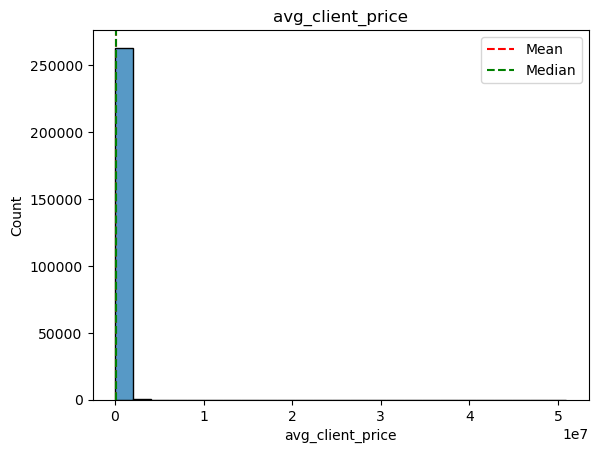

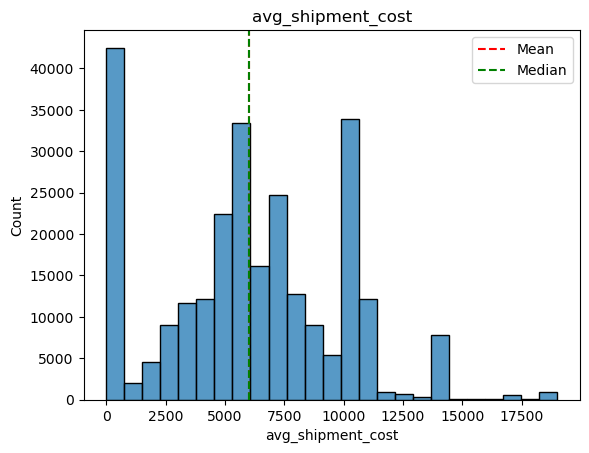

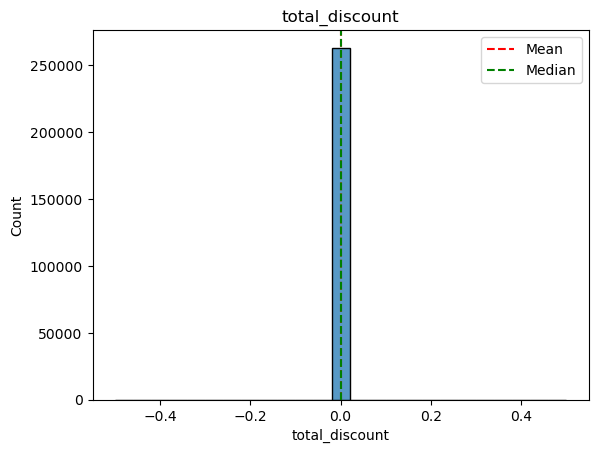

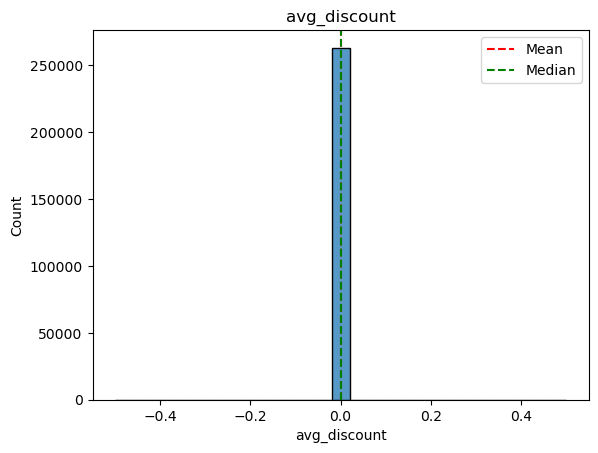

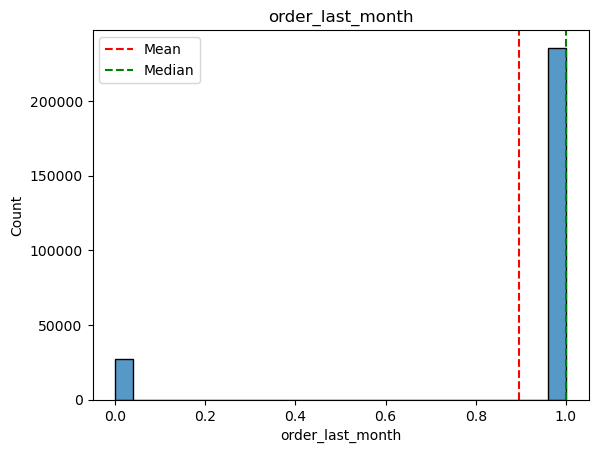

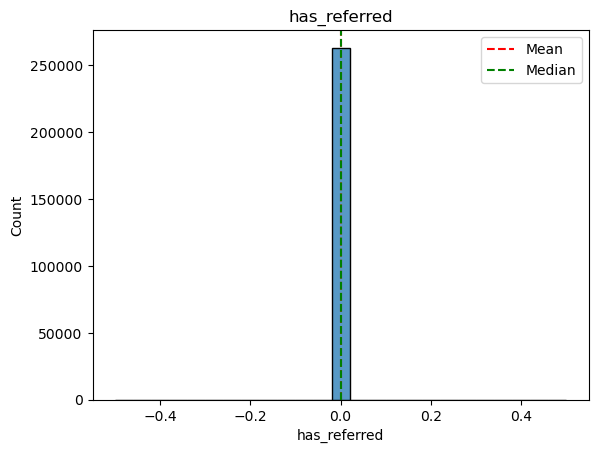

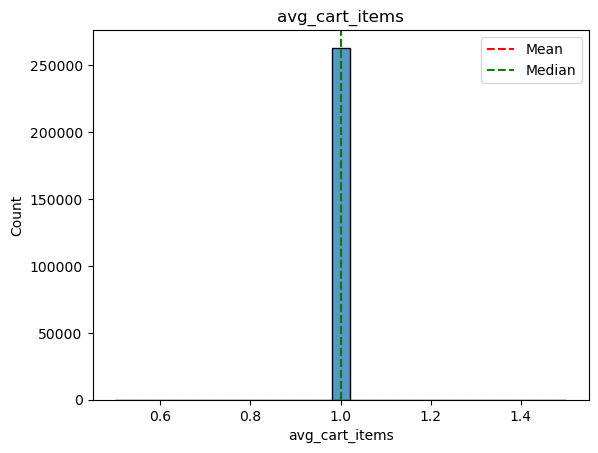

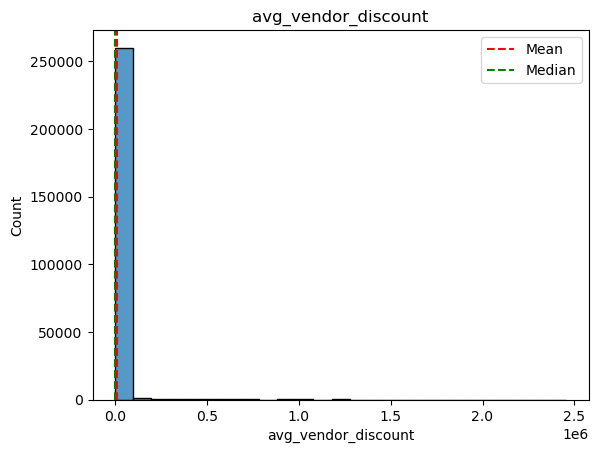

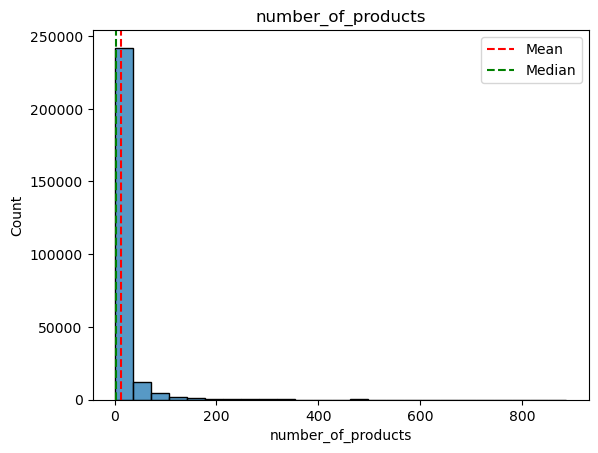

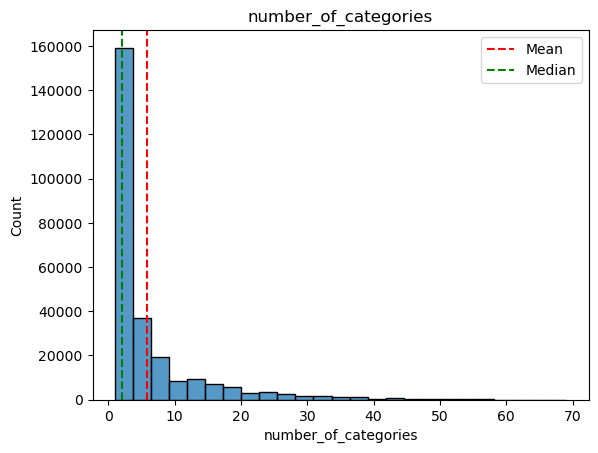

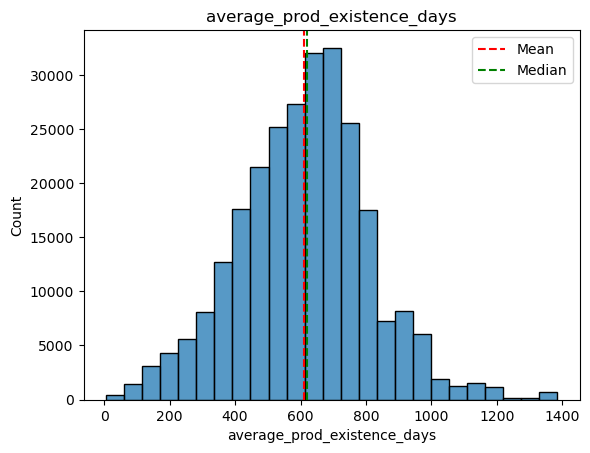

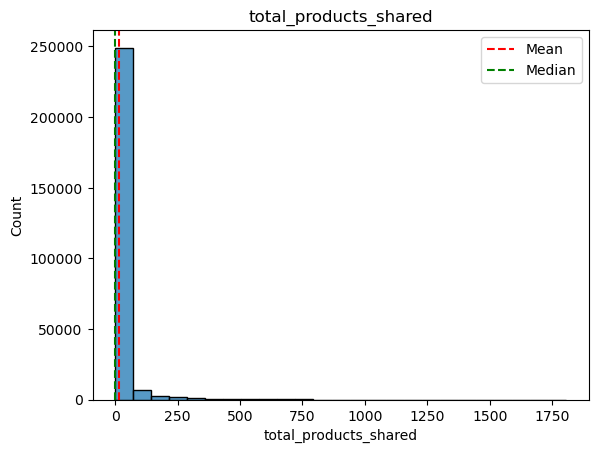

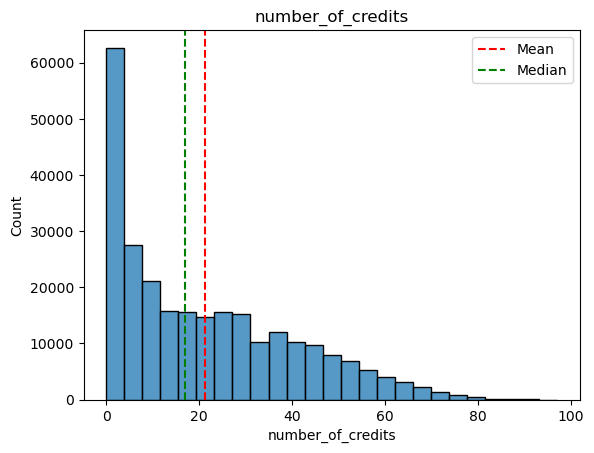

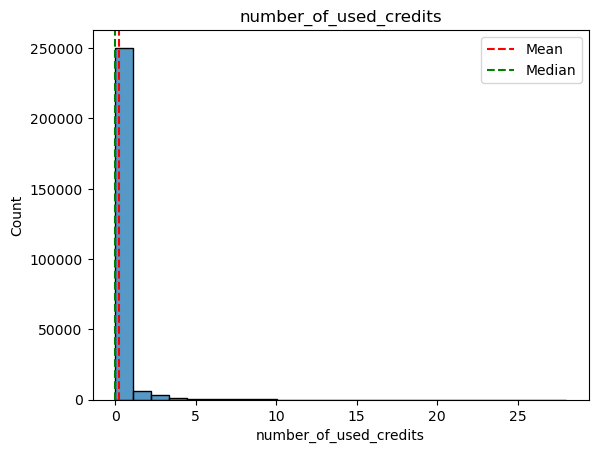

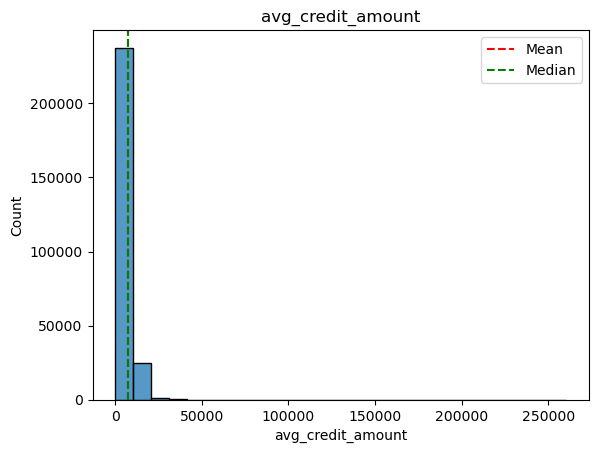

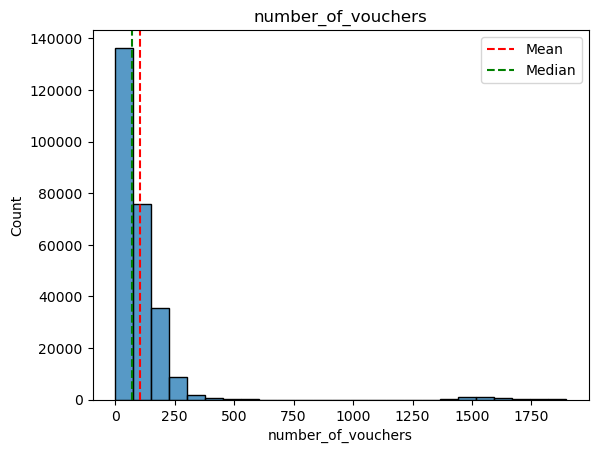

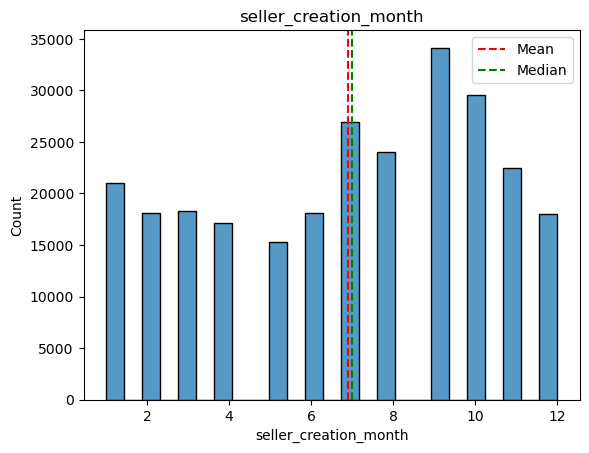

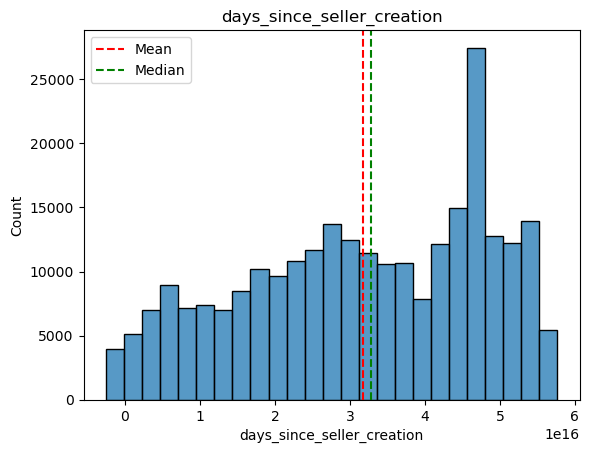

In [31]:
num_col_dist(num_cols, df10)

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


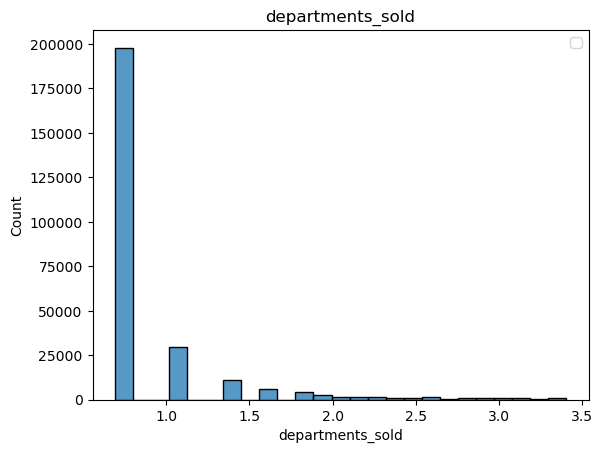

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


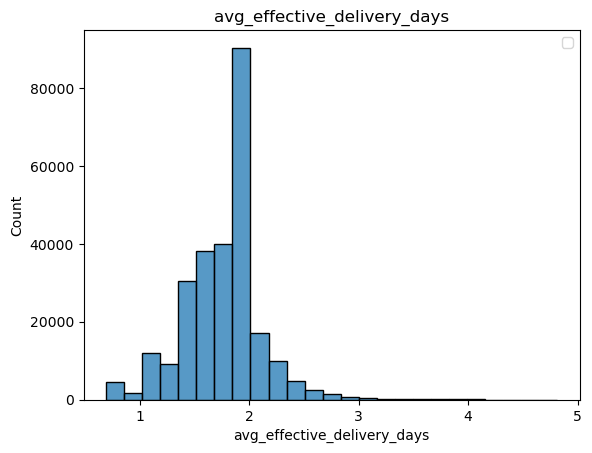

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


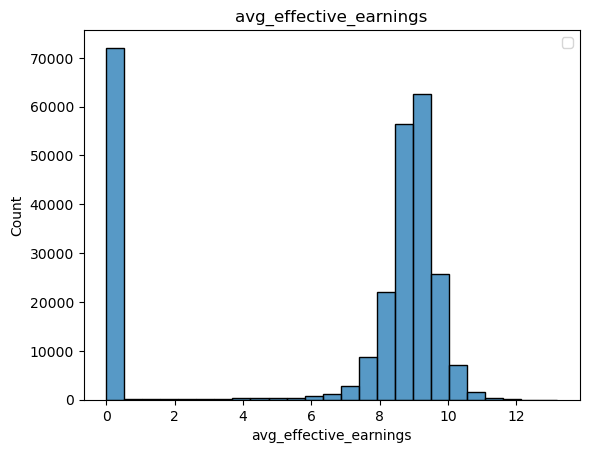

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


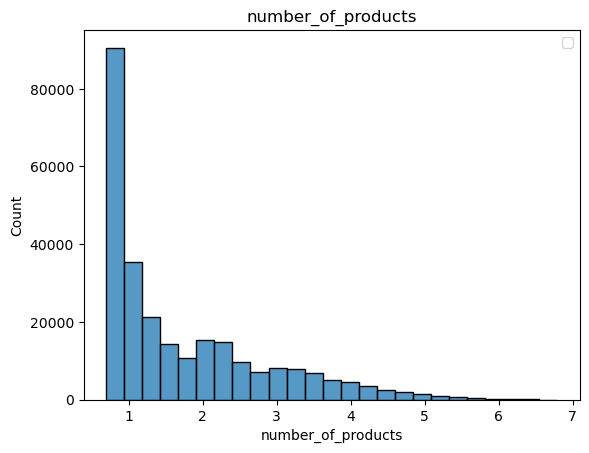

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


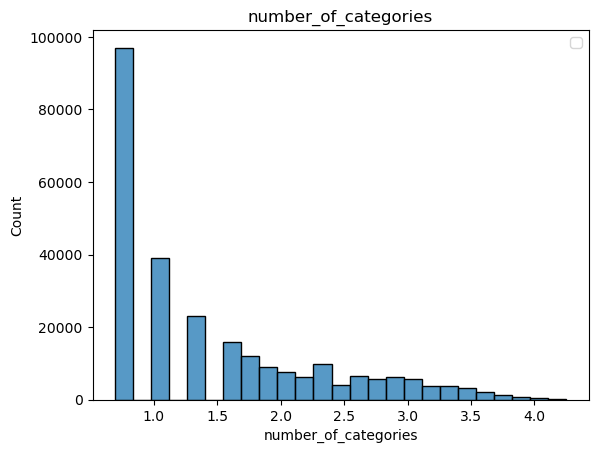

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


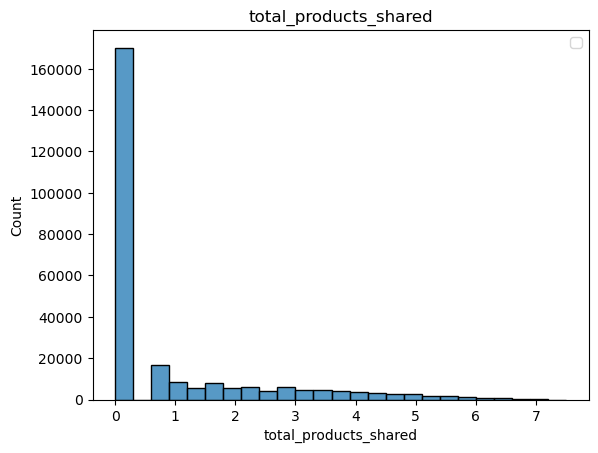

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


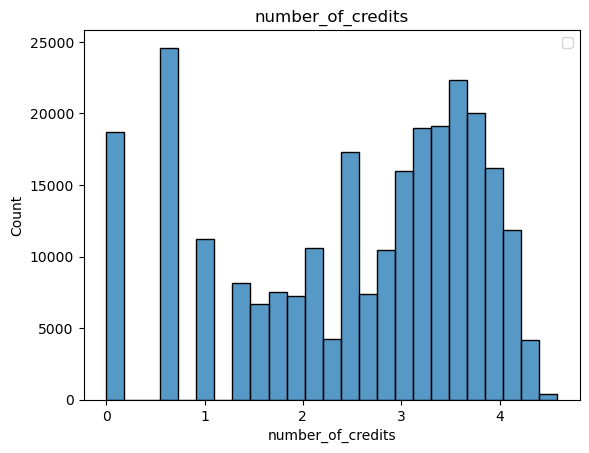

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


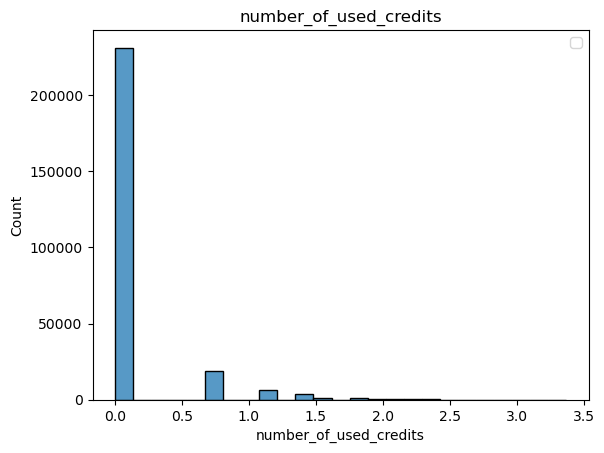

In [32]:
#Applying log transformation
log_cols = ["departments_sold", "avg_effective_delivery_days", "avg_effective_earnings", "number_of_products","number_of_categories", "total_products_shared", "number_of_credits", "number_of_used_credits"]

for c in log_cols:
    plt.figure()
    sns.histplot(data=np.log(df10 +1 ), x=c, bins=25)
    plt.xlabel(c)
    plt.title(c)
    plt.legend()
    plt.show()

In [33]:
#Log transformation:
#Avg effective delivery days
df10["avg_effective_delivery_days"] = np.log(df10["avg_effective_delivery_days"]+1)

#Avg effective earnings
df10["avg_effective_earnings"] = np.log(df10["avg_effective_earnings"]+1)


In [34]:
df10.shape

(263113, 29)

## Splitting & Scaling
- The split data uses DF10, random state 24, test size 20% and stratify
- Smote sampler was used
- Standard Scaler was also used

In [35]:
# splitting Data
X = df10.drop(columns="order_last_month")
y =df10["order_last_month"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

In [36]:
#Smote sampler:
smote = SMOTE(random_state=24)


#Resample the data with Smote
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [37]:
# scale the sampled train data and the unsampled test data
#Standard Scaler on Smote
ss = StandardScaler()
ss_sm = ss.fit(X_train_sm)

#Rescaling the data
X_train_sm_ss = ss_sm.transform(X_train_sm)
X_test_ss_sm = ss_sm.transform(X_test)

In [38]:
#Saving the file
pd.DataFrame(X_train_sm_ss, columns = df10.drop('Unnamed: 0',axis=1).columns).to_csv('../Data/elenas-it1-x_train_sm_ss.csv')
pd.DataFrame(X_test_ss_sm, columns = df10.drop('Unnamed: 0',axis=1).columns).to_csv('../Data/elenas-it1-x_test_sm_ss.csv')
pd.DataFrame(y_train_sm, columns=["order_last_month"]).to_csv('../Data/elenas-it1-y_train_sm2.csv')
pd.DataFrame(y_test, columns=["order_last_month"]).to_csv('../Data/elenas-it1-y_test.csv')


In [39]:
y_train_sm.value_counts()

1    188566
0    188566
Name: order_last_month, dtype: int64

In [40]:
y_test.value_counts()

1    47142
0     5481
Name: order_last_month, dtype: int64

In [41]:
#Shape of the DF:
print(f"""
     X_train_sm_ss: {X_train_sm_ss.shape}
     X_test_ss_sm: {X_test_ss_sm.shape}
     y_train_sm: {y_train_sm.shape}
     y_test: {y_test.shape}
      """)


     X_train_sm_ss: (377132, 28)
     X_test_ss_sm: (52623, 28)
     y_train_sm: (377132,)
     y_test: (52623,)
      


In [42]:
y_test

59896     1
12865     1
163518    1
67933     1
212156    1
         ..
77356     1
212206    1
35667     0
185275    1
50943     0
Name: order_last_month, Length: 52623, dtype: int64